In [1]:
import pandas as pd

# Load the datasets
games = pd.read_csv('games.csv')
players = pd.read_csv('players.csv')
player_play = pd.read_csv('player_play.csv')
plays = pd.read_csv('plays.csv')

# Step 1: Merge the datasets
# Merge player_play with plays to get play details
player_play_merged = player_play.merge(plays, on=['gameId', 'playId'])

# Merge with players to get player details
player_play_merged = player_play_merged.merge(players, on='nflId')

# Merge with games to get game outcomes
combined_data = player_play_merged.merge(games, on='gameId')

In [2]:
# Step 2: Clean the Data
# Check for missing values
print(combined_data.isnull().sum())

# Handle missing values (for this example, we'll fill them with 0 or drop them)
combined_data.fillna(0, inplace=True)  # Fill NaN values with 0

# Convert gameDate to datetime format
combined_data['gameDate'] = pd.to_datetime(combined_data['gameDate'])

gameId               0
playId               0
nflId                0
teamAbbr             0
hadRushAttempt       0
                    ..
gameTimeEastern      0
homeTeamAbbr         0
visitorTeamAbbr      0
homeFinalScore       0
visitorFinalScore    0
Length: 112, dtype: int64


In [3]:
# Step 3: Key Metrics and Features
# Calculate total rushing yards and passing yards per player
aggregate_metrics = combined_data.groupby('nflId').agg(
    total_rushing_yards=pd.NamedAgg(column='rushingYards', aggfunc='sum'),
    total_passing_yards=pd.NamedAgg(column='passingYards', aggfunc='sum'),
    total_plays=pd.NamedAgg(column='playId', aggfunc='count')
).reset_index()

# Count the number of plays for each game without conflicting names
play_counts = combined_data.groupby('gameId')['playId'].count().reset_index(name='play_count')

# Merge play counts back into the combined_data (avoid naming conflicts)
combined_data = combined_data.merge(play_counts, on='gameId', how='left', suffixes=('', '_y'))

# Calculate average yards gained per play, handle division by zero
combined_data['average_yards_gained'] = combined_data['yardsGained'] / combined_data['play_count']

# Replace infinity values with 0
combined_data['average_yards_gained'].replace([float('inf'), -float('inf')], 0, inplace=True)

# Create additional features: total scores per game
total_scores = combined_data.groupby('gameId').agg(
    home_final_score=pd.NamedAgg(column='homeFinalScore', aggfunc='first'),
    visitor_final_score=pd.NamedAgg(column='visitorFinalScore', aggfunc='first')
).reset_index()

# Rename the score columns to avoid conflicts
total_scores.rename(columns={
    'home_final_score': 'home_final_score_new',
    'visitor_final_score': 'visitor_final_score_new'
}, inplace=True)

# Merge total scores back into the combined data
combined_data = combined_data.merge(total_scores, on='gameId', how='left')

# Display the final aggregated metrics and the combined dataset
print(aggregate_metrics.head())


   nflId  total_rushing_yards  total_passing_yards  total_plays
0  33084                   12                  352           90
1  34452                    2                  232           64
2  35443                    0                    0           64
3  35449                    0                    0           32
4  35452                    0                    0           28


/var/folders/8y/m7b7vwqn1gq3s5gg_9vtr5b80000gn/T/ipykernel_70659/3275139307.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['average_yards_gained'].replace([float('inf'), -float('inf')], 0, inplace=True)


In [4]:
print(combined_data[['gameId', 'nflId', 'average_yards_gained', 'home_final_score_new', 'visitor_final_score_new']].head())

       gameId  nflId  average_yards_gained  home_final_score_new  \
0  2022090800  35472              0.002372                    10   
1  2022090800  42392              0.002372                    10   
2  2022090800  42489              0.002372                    10   
3  2022090800  44875              0.002372                    10   
4  2022090800  44985              0.002372                    10   

   visitor_final_score_new  
0                       31  
1                       31  
2                       31  
3                       31  
4                       31  


In [6]:
# Display the first few rows and summary of the dataframe
print(combined_data.head())

       gameId  playId  nflId teamAbbr  hadRushAttempt  rushingYards  \
0  2022090800      56  35472      BUF               0             0   
1  2022090800      56  42392      BUF               0             0   
2  2022090800      56  42489      BUF               0             0   
3  2022090800      56  44875      BUF               0             0   
4  2022090800      56  44985      BUF               0             0   

   hadDropback  passingYards  sackYardsAsOffense  hadPassReception  ...  \
0            0             0                   0                 0  ...   
1            0             0                   0                 0  ...   
2            0             0                   0                 1  ...   
3            0             0                   0                 0  ...   
4            0             0                   0                 0  ...   

    gameDate  gameTimeEastern  homeTeamAbbr  visitorTeamAbbr  homeFinalScore  \
0 2022-09-08         20:20:00            L

In [8]:
print(combined_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19998 entries, 0 to 19997
Columns: 116 entries, gameId to visitor_final_score_new
dtypes: bool(3), datetime64[ns](1), float64(27), int64(50), object(35)
memory usage: 17.3+ MB
None


In [10]:
print(combined_data.describe())

             gameId        playId         nflId  hadRushAttempt  rushingYards  \
count  1.999800e+04  19998.000000  19998.000000    19998.000000  19998.000000   
mean   2.022091e+09   2201.369637  47268.888489        0.020102      0.092659   
min    2.022091e+09     56.000000  33084.000000        0.000000     -4.000000   
25%    2.022091e+09   1071.000000  43641.000000        0.000000      0.000000   
50%    2.022091e+09   2201.000000  46194.000000        0.000000      0.000000   
75%    2.022091e+09   3262.000000  52493.000000        0.000000      0.000000   
max    2.022091e+09   5120.000000  55173.000000        1.000000     57.000000   
std    1.006284e+02   1302.117415   4890.602792        0.140353      1.078582   

        hadDropback  passingYards  sackYardsAsOffense  hadPassReception  \
count  19998.000000  19998.000000        19998.000000      19998.000000   
mean       0.016202      0.158716           -0.011451          0.014401   
min        0.000000    -10.000000          -1

In [11]:
# Check for missing values
missing_values = combined_data.isnull().sum()
print(missing_values[missing_values > 0])

# Check for duplicates
duplicate_rows = combined_data.duplicated().sum()
print(f"Duplicate rows: {duplicate_rows}")

Series([], dtype: int64)
Duplicate rows: 0


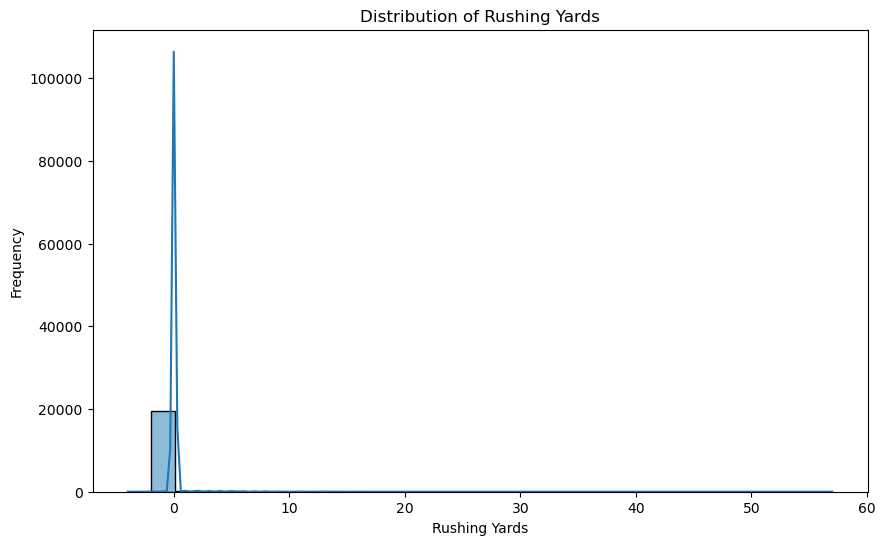

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(combined_data['rushingYards'], bins=30, kde=True)
plt.title('Distribution of Rushing Yards')
plt.xlabel('Rushing Yards')
plt.ylabel('Frequency')
plt.show()

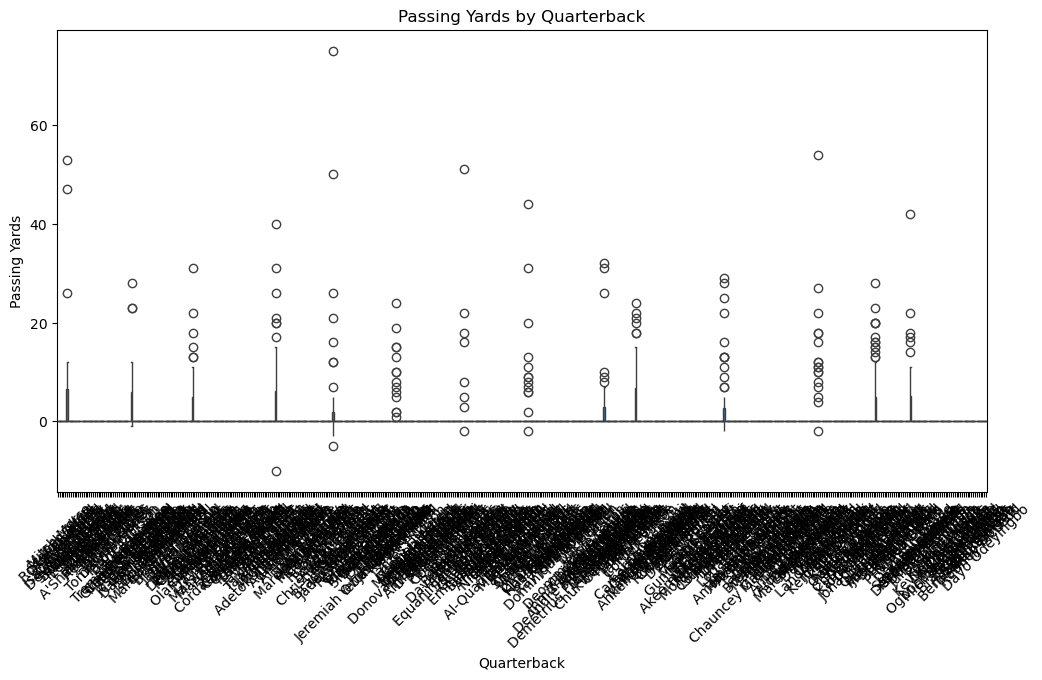

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='displayName', y='passingYards', data=combined_data)
plt.title('Passing Yards by Quarterback')
plt.xticks(rotation=45)
plt.ylabel('Passing Yards')
plt.xlabel('Quarterback')
plt.show()

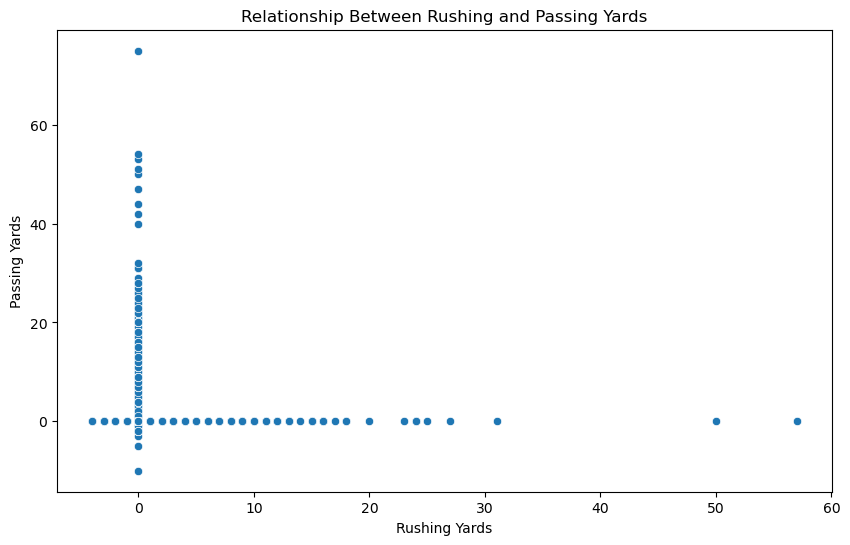

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rushingYards', y='passingYards', data=combined_data)
plt.title('Relationship Between Rushing and Passing Yards')
plt.xlabel('Rushing Yards')
plt.ylabel('Passing Yards')
plt.show()

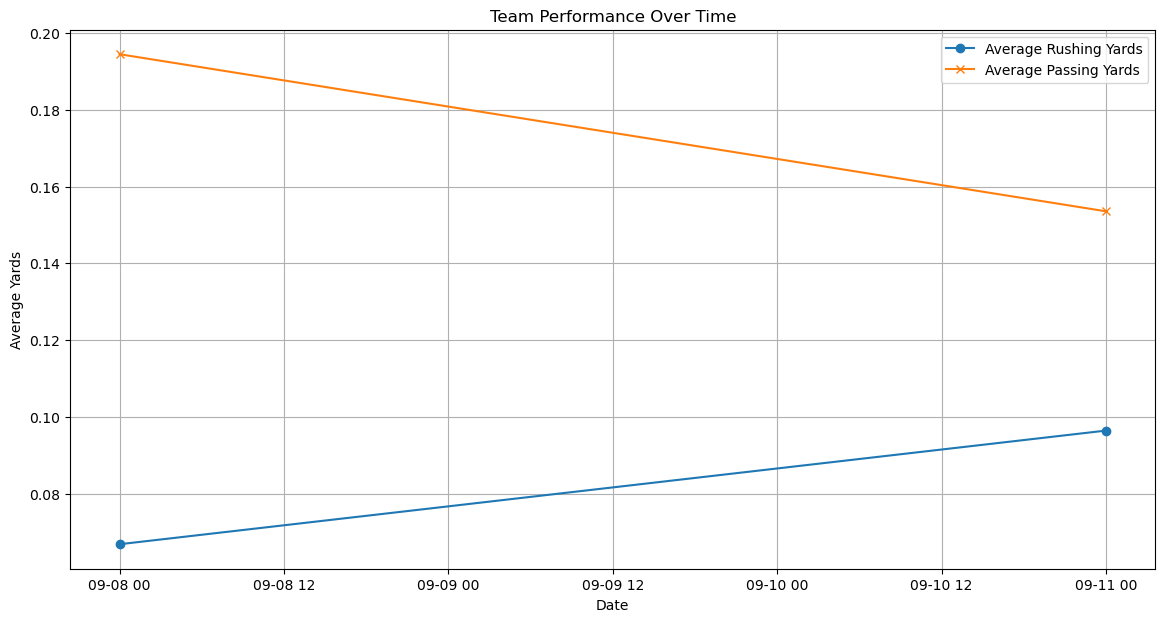

In [17]:
# Convert gameDate to datetime
combined_data['gameDate'] = pd.to_datetime(combined_data['gameDate'])

# Group by date and calculate average rushing and passing yards
performance_over_time = combined_data.groupby('gameDate')[['rushingYards', 'passingYards']].mean().reset_index()

plt.figure(figsize=(14, 7))
plt.plot(performance_over_time['gameDate'], performance_over_time['rushingYards'], label='Average Rushing Yards', marker='o')
plt.plot(performance_over_time['gameDate'], performance_over_time['passingYards'], label='Average Passing Yards', marker='x')
plt.title('Team Performance Over Time')
plt.xlabel('Date')
plt.ylabel('Average Yards')
plt.legend()
plt.grid()
plt.show()